In [1]:
# %matplotlib widget

from __future__ import annotations

import re
from collections import defaultdict
from dataclasses import dataclass, field
from itertools import permutations, product
from math import inf
from random import choice

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from mpl_toolkits.mplot3d import axes3d
from numpy import int_, object_
from numpy.typing import NDArray
from test_utilities import run_tests_params
from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())

<link href="style.css" rel="stylesheet"></link>
<article class="day-desc read-aloud"><h2>--- Day 15: Oxygen System ---</h2><p>Out here in deep space, many things can go wrong. Fortunately, many of those things have <span title="Which indicator lights indicate when the indicator lights have failed?">indicator lights</span>. Unfortunately, one of those lights is lit: the oxygen system for part of the ship has failed!</p>
<p>According to the readouts, the oxygen system must have failed days ago after a rupture in oxygen tank two; that section of the ship was automatically sealed once oxygen levels went dangerously low. A single remotely-operated <em>repair droid</em> is your only option for fixing the oxygen system.</p>
<p>The Elves' care package included an <a href="9">Intcode</a> program (your puzzle input) that you can use to remotely control the repair droid. By running that program, you can direct the repair droid to the oxygen system and fix the problem.</p>
<p>The remote control program executes the following steps in a loop forever:</p>
<ul>
<li>Accept a <em>movement command</em> via an input instruction.</li>
<li>Send the movement command to the repair droid.</li>
<li>Wait for the repair droid to finish the movement operation.</li>
<li>Report on the <em>status</em> of the repair droid via an output instruction.</li>
</ul>
<p>Only four <em>movement commands</em> are understood: north (<code>1</code>), south (<code>2</code>), west (<code>3</code>), and east (<code>4</code>). Any other command is invalid. The movements differ in direction, but not in distance: in a long enough east-west hallway, a series of commands like <code>4,4,4,4,3,3,3,3</code> would leave the repair droid back where it started.</p>
<p>The repair droid can reply with any of the following <em>status</em> codes:</p>
<ul>
<li><code>0</code>: The repair droid hit a wall. Its position has not changed.</li>
<li><code>1</code>: The repair droid has moved one step in the requested direction.</li>
<li><code>2</code>: The repair droid has moved one step in the requested direction; its new position is the location of the oxygen system.</li>
</ul>
<p>You don't know anything about the area around the repair droid, but you can figure it out by watching the status codes.</p>
<p>For example, we can draw the area using <code>D</code> for the droid, <code>#</code> for walls, <code>.</code> for locations the droid can traverse, and empty space for unexplored locations.  Then, the initial state looks like this:</p>
<pre><code>      
      
   D  
      
      
</code></pre>
<p>To make the droid go north, send it <code>1</code>. If it replies with <code>0</code>, you know that location is a wall and that the droid didn't move:</p>
<pre><code>      
   #  
   D  
      
      
</code></pre>
<p>To move east, send <code>4</code>; a reply of <code>1</code> means the movement was successful:</p>
<pre><code>      
   #  
   .D 
      
      
</code></pre>
<p>Then, perhaps attempts to move north (<code>1</code>), south (<code>2</code>), and east (<code>4</code>) are all met with replies of <code>0</code>:</p>
<pre><code>      
   ## 
   .D#
    # 
      
</code></pre>
<p>Now, you know the repair droid is in a dead end. Backtrack with <code>3</code> (which you already know will get a reply of <code>1</code> because you already know that location is open):</p>
<pre><code>      
   ## 
   D.#
    # 
      
</code></pre>
<p>Then, perhaps west (<code>3</code>) gets a reply of <code>0</code>, south (<code>2</code>) gets a reply of <code>1</code>, south again (<code>2</code>) gets a reply of <code>0</code>, and then west (<code>3</code>) gets a reply of <code>2</code>:</p>
<pre><code>      
   ## 
  #..#
  D.# 
   #  
</code></pre>
<p>Now, because of the reply of <code>2</code>, you know you've found the <em>oxygen system</em>! In this example, it was only <code><em>2</em></code> moves away from the repair droid's starting position.</p>
<p><em>What is the fewest number of movement commands</em> required to move the repair droid from its starting position to the location of the oxygen system?</p>
</article>


In [2]:
from math import inf
from typing import Generator


class IntcodeComputer:
    def __init__(self, s: str) -> None:
        self.state = {a: int(i) for a, i in enumerate(s.split(","))}
        self.ip = 0

    def run(self) -> Generator[int | None, int, None]:
        offset = 0

        while True:
            mode_c, mode_b, mode_a, opcode = self.opcode()

            if opcode == 1:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                self.state[self.adress(mode_a, offset)] = c + b
            elif opcode == 2:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                self.state[self.adress(mode_a, offset)] = c * b
            elif opcode == 3:
                f = yield
                self.state[self.adress(mode_c, offset)] = f
            elif opcode == 4:
                c = self.value(mode_c, offset)
                yield c
            elif opcode == 5:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                if c != 0:
                    self.ip = b
            elif opcode == 6:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                if c == 0:
                    self.ip = b
            elif opcode == 7:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                self.state[self.adress(mode_a, offset)] = 1 if c < b else 0
            elif opcode == 8:
                c = self.value(mode_c, offset)
                b = self.value(mode_b, offset)
                self.state[self.adress(mode_a, offset)] = 1 if c == b else 0
            elif opcode == 9:
                offset += self.value(mode_c, offset)
            elif opcode == 99:
                return
            else:
                raise ValueError("1202 program alarm")

    def opcode(self):
        code = self.state[self.ip]
        self.ip += 1
        opcode = code % 100
        code //= 100
        mode_c = code % 10
        code //= 10
        mode_b = code % 10
        code //= 10
        mode_a = code % 10
        return mode_c, mode_b, mode_a, opcode

    def value(self, mode: int, offset: int) -> int:
        adress = self.adress(mode, offset)
        if adress > -1:
            if adress not in self.state:
                self.state[adress] = 0
            return self.state[adress]

        raise ValueError(
            f"Adress should be bigger then 0: adress={self.state[self.ip] + offset}"
        )

    def adress(self, mode: int, offset: int) -> int:
        ip = self.ip
        self.ip += 1

        if mode == 0:
            return self.state[ip]

        if mode == 1:
            return ip

        if mode == 2:
            return self.state[ip] + offset

        raise ValueError(f"Unknown adress mode: mode={mode}")

    def __repr__(self) -> str:
        return ",".join(str(i) for i in self.state)

In [3]:
with open("../input/day15.txt") as f:
    puzzle = f.read()

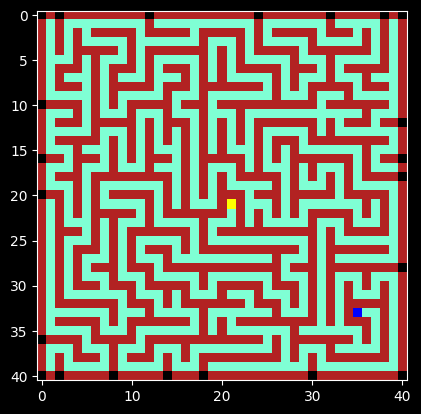

In [4]:
from collections import deque
from copy import copy, deepcopy
from matplotlib import colors
from more_itertools import minmax


class RepairDroid:
    directions = [(None, None), (0, -1), (0, 1), (-1, 0), (1, 0)]

    def __init__(self, program: str) -> None:
        self.intcode = IntcodeComputer(program)
        self.map, self.ox_gen = self.map_area()

    def map_area(self) -> dict[tuple[int, int], int]:
        map = {(0, 0): 1}
        queue = deque(
            [
                (0, 0, 1, deepcopy(self.intcode)),
                (0, 0, 2, deepcopy(self.intcode)),
                (0, 0, 3, deepcopy(self.intcode)),
                (0, 0, 4, deepcopy(self.intcode)),
            ]
        )
        o_x, o_y = -1, -1

        while queue:
            x, y, command, computer = queue.popleft()
            iter = computer.run()
            iter.send(None)

            # Accept a movement command via an input instruction.
            #   - Only four movement commands are understood:
            #     north (1), south (2), west (3), and east (4)
            # Send the movement command to the repair droid.
            dx, dy = self.directions[command]
            xx, yy = x + dx, y + dy
            status = iter.send(command)

            # Wait for the repair droid to finish the movement operation.
            # Report on the status of the repair droid via an output instruction.
            if status == 0:
                #   0: The repair droid hit a wall. Its position has not changed.
                if (xx, yy) not in map:
                    map[(xx, yy)] = 0
            elif status in (1, 2):
                #   1: The repair droid has moved one step in the requested direction.
                if (xx, yy) not in map:
                    map[(xx, yy)] = status

                if status == 2:
                    o_x, o_y = x, y

                for d in range(1, 5):
                    dx, dy = self.directions[d]
                    if (xx + dx, yy + dy) not in map:
                        queue.append((xx, yy, d, deepcopy(computer)))

            else:
                raise ValueError(f"Unknow staus {status}")

        return map, (o_x, o_y)

    def shortest_path(self) -> int:
        directions = self.directions[1:]
        seen = set()
        queue = deque([(0, 0)])
        steps = 0

        while queue:
            for _ in range(len(queue)):
                x, y = queue.popleft()

                if self.map.get((x, y), 0) == 2:
                    return steps

                if (x, y) in seen:
                    continue

                seen.add((x, y))

                for dx, dy in directions:
                    if self.map.get((x + dx, y + dy), 0) != 0:
                        queue.append((x + dx, y + dy))

            steps += 1

        return -1

    def minutes_to_fill_with_oxygen(self) -> int:
        directions = self.directions[1:]
        seen = set()
        queue = deque([self.ox_gen])
        steps = 0

        while queue:
            for _ in range(len(queue)):
                x, y = queue.popleft()

                if (x, y) in seen:
                    continue

                seen.add((x, y))

                for dx, dy in directions:
                    if self.map.get((x + dx, y + dy), 0) != 0:
                        queue.append((x + dx, y + dy))

            steps += 1

        return steps - 1

    def __repr__(self) -> str:
        min_x, max_x = minmax(x for x, _ in self.map.keys())
        min_y, max_y = minmax(y for _, y in self.map.keys())

        s = f"{min_x=}, {max_x=}, {min_y=}, {max_y=}\n\n"
        mp = [
            [str(self.map.get((x, y), " ")) for x in range(min_x, max_x + 1)]
            for y in range(min_y, max_y + 1)
        ]

        return s + "\n".join("".join(c for c in l) for l in mp)

    def print_map(self) -> str:
        min_x, max_x = minmax(x for x, _ in self.map.keys())
        min_y, max_y = minmax(y for _, y in self.map.keys())

        mp = [
            [self.map.get((x, y), 4) for x in range(min_x, max_x + 1)]
            for y in range(min_y, max_y + 1)
        ]
        mp[min_y + 1][min_x + 1] = 3
        cmap = colors.ListedColormap(
            ["Firebrick", "Aquamarine", "blue", "yellow", "black"]
        )
        plt.imshow(mp, cmap=cmap)
        plt.show()


rd = RepairDroid(puzzle)
rd.print_map()

In [5]:
print(f"Part I: {rd.shortest_path()}")

Part I: 210


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>210</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>You quickly repair the oxygen system; oxygen gradually fills the area.</p>
<p>Oxygen starts in the location containing the repaired oxygen system. It takes <em>one minute</em> for oxygen to spread to all open locations that are adjacent to a location that already contains oxygen. Diagonal locations are <em>not</em> adjacent.</p>
<p>In the example above, suppose you've used the droid to explore the area fully and have the following map (where locations that currently contain oxygen are marked <code>O</code>):</p>
<pre><code> ##   
#..## 
#.#..#
#.O.# 
 ###  
</code></pre>
<p>Initially, the only location which contains oxygen is the location of the repaired oxygen system.  However, after one minute, the oxygen spreads to all open (<code>.</code>) locations that are adjacent to a location containing oxygen:</p>
<pre><code> ##   
#..## 
#.#..#
#OOO# 
 ###  
</code></pre>
<p>After a total of two minutes, the map looks like this:</p>
<pre><code> ##   
#..## 
#O#O.#
#OOO# 
 ###  
</code></pre>
<p>After a total of three minutes:</p>
<pre><code> ##   
#O.## 
#O#OO#
#OOO# 
 ###  
</code></pre>
<p>And finally, the whole region is full of oxygen after a total of four minutes:</p>
<pre><code> ##   
#OO## 
#O#OO#
#OOO# 
 ###  
</code></pre>
<p>So, in this example, all locations contain oxygen after <code><em>4</em></code> minutes.</p>
<p>Use the repair droid to get a complete map of the area. <em>How many minutes will it take to fill with oxygen?</em></p>
</article>

</main>


In [6]:
print(f"Part II: {rd.minutes_to_fill_with_oxygen()}")

Part II: 290


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>290</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>

</main>
